In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
def get_xes_pumped(filename, DIR, DIRBS, roi, channel, ynstamp):
    numstds = 2
    minIzero = 0.002
    image_threshold = 1
    hot_pixel = 5

    print(DIR + filename + ".JF02T09V02crop.h5")
    print()
    print(DIRBS + filename + ".BSREAD.h5")
    
    Energy_eV_pump = np.empty(0)
    Energy_eV_unpump = np.empty(0)
    
    FloFEL_pump_total = np.empty(0)
    FloFEL_unpump_total = np.empty(0)
    
    images_off, images_on, pulse_ids_off, pulse_ids_on = \
        load_JF_cropped_data_pump(DIR + filename + ".JF02T09V02crop.h5", roi, 50, 25, nshots=None)
    (FloFEL_pump, FloFEL_unpump, IzeroFEL_pump, IzeroFEL_unpump, JFIDs_pump, JFIDs_unpump, Energy_pump, Energy_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_BS_pulse_ids, channel)
    (_, _, _, _, _, _, Laser_pump, Laser_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_PIPS_fluo, channel)
    
    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.append(Energy_eV_pump, np.mean(Energy_pump))
    
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.append(Energy_eV_unpump, np.mean(Energy_unpump))
    
    FloFEL_pump_total = np.append(FloFEL_pump_total, np.mean(FloFEL_pump))
    FloFEL_unpump_total = np.append(FloFEL_unpump_total, np.mean(FloFEL_unpump))
    
    idcheck = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, JFIDs_pump, pulse_ids_off, JFIDs_unpump)]
    IDCheck = sum([int(x) for x in idcheck])
    
    if IDCheck:
        print("passed ID check")
    else:
        print("failed ID check")   
    
    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))

    
    print('number of frames')
    print(images_on.shape[0])
    print(images_off.shape[0])

    images_good_on = images_on
    images_good_off = images_off

    images_thr_on = images_good_on.copy()
    images_thr_on[images_good_on < image_threshold] = 0
    images_thr_on[images_good_on > hot_pixel] = 0
    
    images_thr_off = images_good_off.copy()
    images_thr_off[images_good_off < image_threshold] = 0
    images_thr_off[images_good_off > hot_pixel] = 0

    conditionMax = IzeroFEL_pump < IzeroMedian+numstds*IzeroSTD
    conditionMin = IzeroFEL_pump > IzeroMedian-numstds*IzeroSTD
    conditionLow = IzeroFEL_pump > minIzero
    condition = np.logical_and.reduce((conditionLow, conditionMin, conditionMax)).T[0]
    images_thr_on = images_thr_on[condition]
    
    conditionMax = IzeroFEL_unpump < IzeroMedian+numstds*IzeroSTD
    conditionMin = IzeroFEL_unpump > IzeroMedian-numstds*IzeroSTD
    conditionLow = IzeroFEL_unpump > minIzero
    condition = np.logical_and.reduce((conditionLow, conditionMin, conditionMax)).T[0]

    
    images_thr_off = images_thr_off[condition]
        

    print('number of surviving frames')
    print(images_thr_on.shape[0])
    print(images_thr_off.shape[0])
    
    XES_on = images_thr_on.sum(axis=0)/images_thr_on.shape[0]
    XES_off = images_thr_off.sum(axis=0)/images_thr_off.shape[0]
    
    stamp = make_bar_stamp(XES_on.shape[1],XES_on.shape[0])
    
    print(XES_on.shape)
    print(stamp.shape)
    if ynstamp:

        XES_on = XES_on * stamp
        XES_off = XES_off * stamp

    return XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, FloFEL_pump_total, FloFEL_unpump_total


In [4]:
def make_bar_stamp(dimension_x, dimension_y):

    X,Y = np.meshgrid(np.linspace(0,dimension_x-1,dimension_x),np.linspace(0,dimension_y-1,dimension_y))

    Z = np.zeros([dimension_y,dimension_x])+1

    condition = np.logical_and(Y<260, Y>253)
    Z[condition] = 0
    
    Z[Y>320] = 0
    Z[Y < 200] = 0

    condition = np.logical_not(np.logical_and(X<140, X>100))
    Z[condition] = 0

    #plt.figure()
    #plt.imshow(Z)
    
    #plt.colorbar()
    
    return Z

Run for RIXS

In [5]:
scannum = [5]

for jj in range(len(scannum)):

    if scannum[jj] < 10:
        name_zeros = '00'
    else:
        name_zeros = '0'
    
    filename_base = "RuBpy3_monoscan_" + name_zeros + str(scannum[jj]) + "_step00"
    scan_name = "RuBpy3_monoscan_" + name_zeros + str(scannum[jj])
    DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
    numfiles = 35+1
    #numfiles = 3

    eV_on_01 = np.empty(0)
    eV_off_01 = np.empty(0)
    
    Fluo_pump = np.empty(0)
    Fluo_unpump = np.empty(0)
    

    for ii in range(numfiles):

        XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%02d' % (ii+0), DIR, DIRBS, 2, channel_energy, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()
        
        
        if ii == 0 & jj == 0:
            RIXS_on_01 = XES_on.sum(axis=0)
            RIXS_off_01 = XES_off.sum(axis=0)
            eV_on_01 = Energy_eV_pump
            eV_off_01 = Energy_eV_unpump
            Fluo_pump = fluo_pump
            Fluo_unpump = fluo_unpump
        else:
            RIXS_on_01 = np.vstack((RIXS_on_01,XES_on.sum(axis=0)))
            RIXS_off_01 = np.vstack((RIXS_off_01,XES_off.sum(axis=0)))
            eV_on_01 = np.append(eV_on_01, Energy_eV_pump)
            eV_off_01 = np.append(eV_off_01, Energy_eV_unpump)
            Fluo_pump = np.append(Fluo_pump, fluo_pump)
            Fluo_unpump = np.append(Fluo_unpump, fluo_unpump)
            
            

/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0000.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0000.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
475
480
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0001.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0001.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
477
470
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0002.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0002.BSREAD.h5
images_roi2
SLA

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
470
483
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0022.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0022.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
479
471
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0023.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_005/RuBpy3_monoscan_005_step0023.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
479
475
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_m

In [6]:
scannum = [17]

for jj in range(len(scannum)):

    filename_base = "RuBpy3_monoscan_0"+str(scannum[jj])+"_step00"
    scan_name = "RuBpy3_monoscan_0"+str(scannum[jj])
    DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
    DIRBS = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
    numfiles = 35+1
    #numfiles = 3

    eV_on_02 = np.empty(0)
    eV_off_02 = np.empty(0)
    
    Fluo_pump_02 = np.empty(0)
    Fluo_unpump_02 = np.empty(0)
    

    for ii in range(numfiles):

        XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
            get_xes_pumped(filename_base + '%02d' % (ii+0), DIR, DIRBS, 2, channel_energy, True)

        if False:

            plt.figure()
            plt.subplot(1,2,1)
            plt.imshow(XES_on, vmax = 0.001)
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(XES_off, vmax = 0.001)
            plt.colorbar()
            plt.tight_layout()
        
        
        if ii == 0 & jj == 0:
            RIXS_on_02 = XES_on.sum(axis=0)
            RIXS_off_02 = XES_off.sum(axis=0)
            eV_on_02 = Energy_eV_pump
            eV_off_02 = Energy_eV_unpump
            Fluo_pump_02 = fluo_pump
            Fluo_unpump_02 = fluo_unpump
        else:
            RIXS_on_02 = np.vstack((RIXS_on_02,XES_on.sum(axis=0)))
            RIXS_off_02 = np.vstack((RIXS_off_02,XES_off.sum(axis=0)))
            eV_on_02 = np.append(eV_on_02, Energy_eV_pump)
            eV_off_02 = np.append(eV_off_02, Energy_eV_unpump)
            Fluo_pump_02 = np.append(Fluo_pump_02, fluo_pump)
            Fluo_unpump_02 = np.append(Fluo_unpump_02, fluo_unpump)

/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0000.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0000.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
479
479
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0001.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0001.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
477
477
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0002.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0002.BSREAD.h5
images_roi2
SLA

SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
469
475
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0022.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0022.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
466
482
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0023.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_017/RuBpy3_monoscan_017_step0023.BSREAD.h5
images_roi2
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
500
500
number of surviving frames
479
479
(512, 300)
(512, 300)
/das/work/p17/p17983/cropped_data/scan_data/RuBpy3_m

<IPython.core.display.Javascript object>


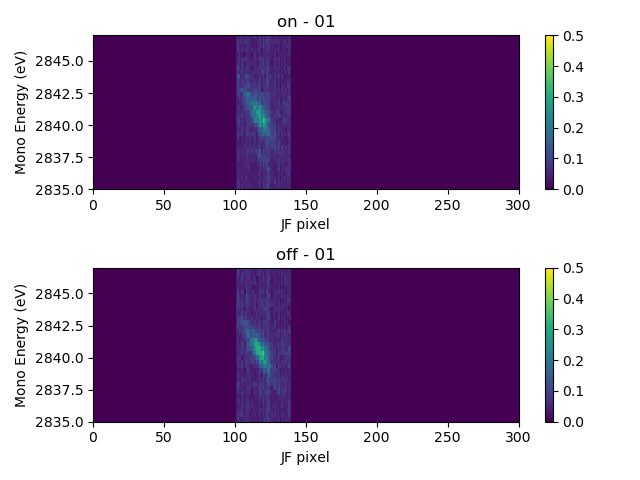

<IPython.core.display.Javascript object>


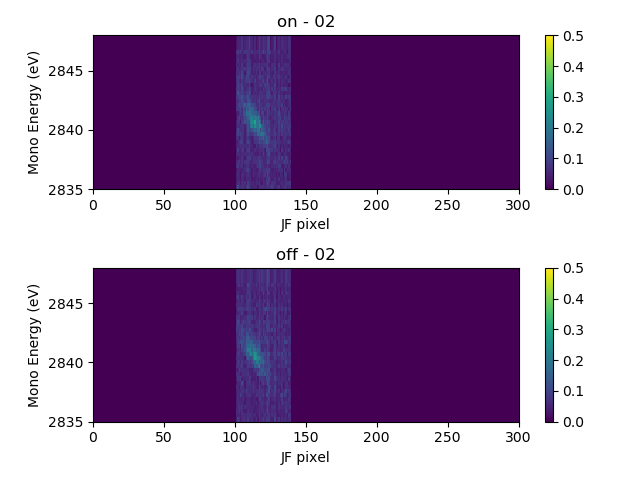

In [7]:
X,Y = np.meshgrid(np.linspace(0,RIXS_on_01.shape[1],RIXS_on_01.shape[1]+1),eV_on_01)
plt.figure()
plt.subplot(2,1,1)
plt.pcolor(X,Y,RIXS_on_01, vmax = .5)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('on - 01')

X,Y = np.meshgrid(np.linspace(0,RIXS_off_01.shape[1],RIXS_off_01.shape[1]+1),eV_off_01)
plt.subplot(2,1,2)
plt.pcolor(X,Y,RIXS_off_01, vmax = 0.5)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('off - 01')

plt.tight_layout()


X,Y = np.meshgrid(np.linspace(0,RIXS_on_02.shape[1],RIXS_on_02.shape[1]+1),eV_on_02)
plt.figure()
plt.subplot(2,1,1)
plt.pcolor(X,Y,RIXS_on_02, vmax = .5)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('on - 02')

X,Y = np.meshgrid(np.linspace(0,RIXS_off_02.shape[1],RIXS_off_02.shape[1]+1),eV_off_02)
plt.subplot(2,1,2)
plt.pcolor(X,Y,RIXS_off_02, vmax = 0.5)
plt.colorbar()
plt.xlabel('JF pixel')
plt.ylabel('Mono Energy (eV)')
plt.title('off - 02')

plt.tight_layout()

<IPython.core.display.Javascript object>


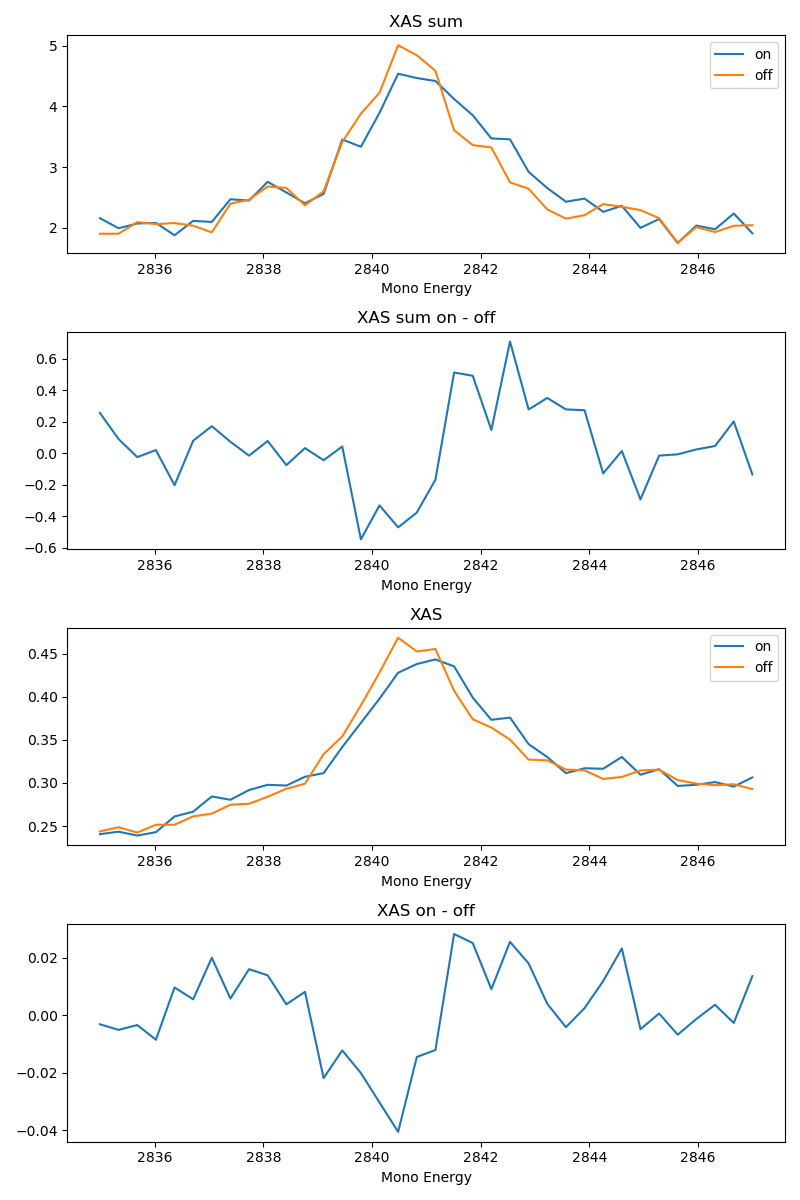

<IPython.core.display.Javascript object>


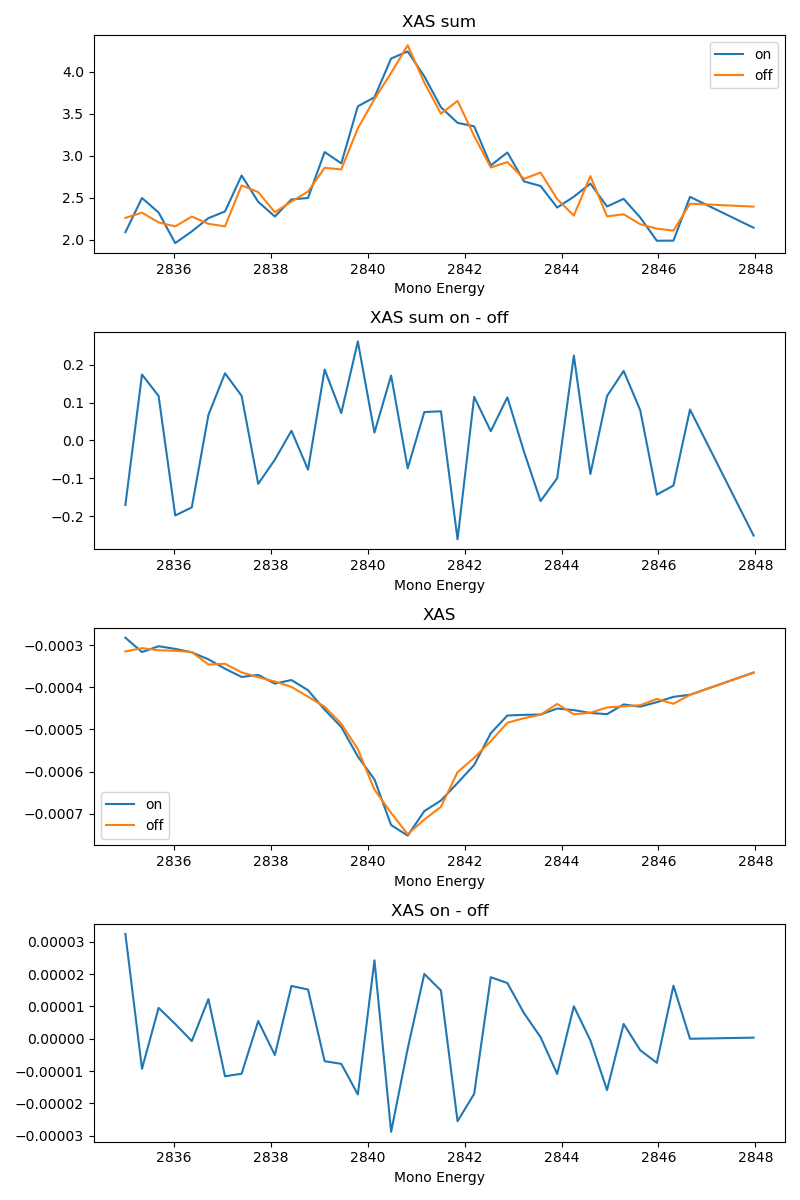

In [8]:
plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(eV_on_01, RIXS_on_01.sum(axis=1), label = "on")
plt.plot(eV_off_01, RIXS_off_01.sum(axis=1), label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS sum')
plt.legend()

plt.subplot(4,1,2)
plt.plot(eV_off_01, RIXS_on_01.sum(axis=1)-RIXS_off_01.sum(axis=1))
plt.xlabel('Mono Energy')
plt.title('XAS sum on - off')

plt.subplot(4,1,3)
plt.plot(eV_on_01, Fluo_pump, label = "on")
plt.plot(eV_off_01, Fluo_unpump, label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS')
plt.legend()

plt.subplot(4,1,4)
plt.plot(eV_off_01, Fluo_pump-Fluo_unpump)
plt.xlabel('Mono Energy')
plt.title('XAS on - off')


plt.tight_layout()


plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(eV_on_02, RIXS_on_02.sum(axis=1), label = "on")
plt.plot(eV_off_02, RIXS_off_02.sum(axis=1), label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS sum')
plt.legend()

plt.subplot(4,1,2)
plt.plot(eV_off_02, RIXS_on_02.sum(axis=1)-RIXS_off_02.sum(axis=1))
plt.xlabel('Mono Energy')
plt.title('XAS sum on - off')

plt.subplot(4,1,3)
plt.plot(eV_on_02, Fluo_pump_02, label = "on")
plt.plot(eV_off_02, Fluo_unpump_02, label = 'off')
plt.xlabel('Mono Energy')
plt.title('XAS')
plt.legend()

plt.subplot(4,1,4)
plt.plot(eV_off_02, Fluo_pump_02-Fluo_unpump_02)
plt.xlabel('Mono Energy')
plt.title('XAS on - off')

plt.tight_layout()

<IPython.core.display.Javascript object>


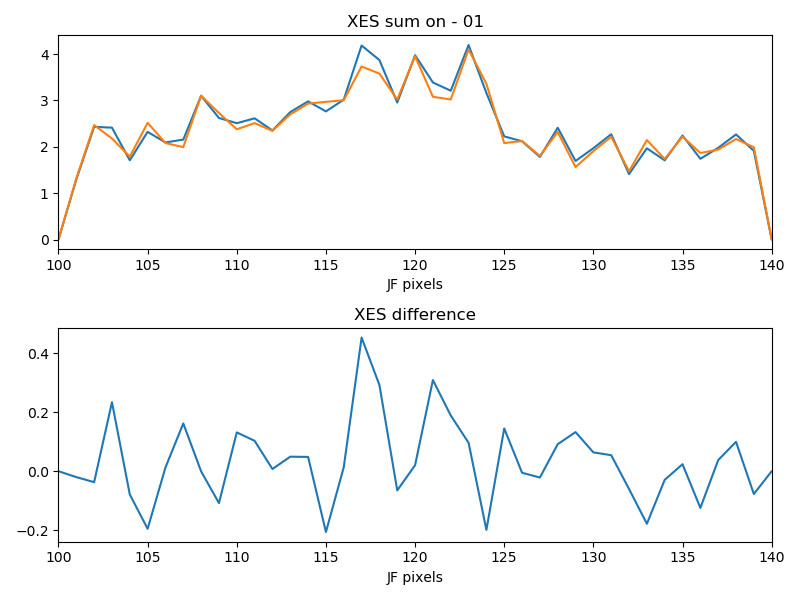

<IPython.core.display.Javascript object>


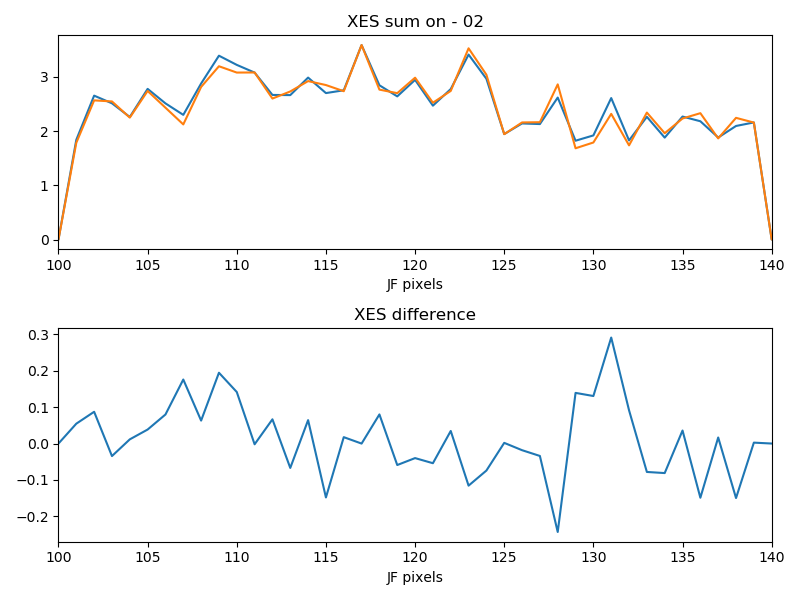

In [9]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(RIXS_on_01.sum(axis=0), label = "on")
plt.plot(RIXS_off_01.sum(axis=0), label = "off")
plt.xlabel('JF pixels')
plt.title('XES sum on - 01')
plt.xlim([100,140])

plt.subplot(2,1,2)
plt.plot(RIXS_on_01.sum(axis=0) - RIXS_off_01.sum(axis=0))
plt.xlabel('JF pixels')
plt.title('XES difference')
plt.xlim([100,140])

plt.tight_layout()

plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(RIXS_on_02.sum(axis=0), label = "on")
plt.plot(RIXS_off_02.sum(axis=0), label = "off")
plt.xlabel('JF pixels')
plt.title('XES sum on - 02')
plt.xlim([100,140])

plt.subplot(2,1,2)
plt.plot(RIXS_on_02.sum(axis=0) - RIXS_off_02.sum(axis=0))
plt.xlabel('JF pixels')
plt.title('XES difference')
plt.xlim([100,140])

plt.tight_layout()